This example demonstrates inversion for the scattering potential with Born modelling, commonly known as imaging. We just run one iteration of optimisation, so this is essentially Reverse-Time Migration (RTM), but we could run more iteration to perform Least-Squares RTM (LSRTM)

Born modelling propagates a wavefield in a “background” velocity model. This wavefield interacts with a provided scattering potential at each time step to produce a source term for a second wavefield. This second wavefield, the scattered wavefield, is also propagated using the background velocity model, and it is from this scattered wavefield that receivers record their data. The recorded data should therefore only contain singly-scattered waves.

We begin by loading the Marmousi 1 velocity model, as in the forward modelling example. We assume, however, that we don’t know the true velocity and only have a smooth approximation of it. We thus smooth the velocity using a Gaussian filter. Because this smooth model doesn’t need to be stored at as high a resolution as the true model, and to reduce computational costs, we downsample the model by a factor of two in each dimension:

In [1]:
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
# import deepwave
# from deepwave import scalar_born

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ny = 2301
nx = 751
dx = 4.0
v = torch.from_file('marmousi_vp.bin',
                    size=ny*nx).reshape(ny, nx)

In [3]:
# Smooth to use as migration model
v_mig = torch.tensor(1/gaussian_filter(1/v.numpy(), 40))
v_mig = v_mig[::2, ::2].to(device)
ny = v_mig.shape[0]
nx = v_mig.shape[1]
dx *= 2

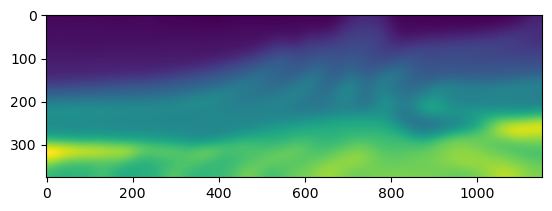

In [17]:
plt.imshow(v_mig.cpu().T)
plt.show()

In [7]:
n_shots = 115

n_sources_per_shot = 1
d_source = 10  # 10 * 8m = 80m
first_source = 5  # 5 * 8m = 40m
source_depth = 1  # 1 * 8m = 8m

n_receivers_per_shot = 384
d_receiver = 3  # 3 * 8m = 24m
first_receiver = 0  # 0 * 8m = 0m
receiver_depth = 1  # 1 * 8m = 8m

freq = 25
nt = 750
dt = 0.004
peak_time = 1.5 / freq

In [8]:
# source_locations
source_locations = torch.zeros(n_shots, n_sources_per_shot, 2,
                               dtype=torch.long, device=device)
source_locations[..., 1] = source_depth
source_locations[:, 0, 0] = torch.arange(n_shots) * d_source + first_source

# receiver_locations
receiver_locations = torch.zeros(n_shots, n_receivers_per_shot, 2,
                                 dtype=torch.long, device=device)
receiver_locations[..., 1] = receiver_depth
receiver_locations[:, :, 0] = (
    (torch.arange(n_receivers_per_shot) * d_receiver + first_receiver)
    .repeat(n_shots, 1)
)

In [9]:
# source_amplitudes
source_amplitudes = (
    deepwave.wavelets.ricker(freq, nt, dt, peak_time)
    .repeat(n_shots, n_sources_per_shot, 1)
    .to(device)
)

NameError: name 'deepwave' is not defined

We load the data that we generated in the previous example as our target “observed data”. Inversion will try to update the scattering potential so that the output of Born modelling matches this observed data:

In [10]:
# Load observed data
observed_data = (
    torch.from_file('marmousi_data.bin',
                    size=n_shots*n_receivers_per_shot*nt)
    .reshape(n_shots, n_receivers_per_shot, nt)
    .to(device)
)

Born modelling only produces singly-scattered waves, however, while the observed dataset contains strong direct arrivals. Trying to get Born modelling to match these direct arrivals would cause strong artefacts. We thus create a mask that attempts to attenuate the direct arrivals in the observed data and that we will also apply to the output of Born modelling. To avoid introducing high frequencies into the data with a sharp cut-off, we use a tapered mute:

In [11]:
# Create mask to attenuate direct arrival
mask = torch.ones_like(observed_data)
flat_len = 100
taper_len = 200
taper = torch.cos(torch.arange(taper_len)/taper_len * torch.pi/2)
mute_len = flat_len + 2*taper_len
mute = torch.zeros(mute_len, device=device)
mute[:taper_len] = taper
mute[-taper_len:] = taper.flip(0)
v_direct = 1700
for shot_idx in range(n_shots):
    sx = (shot_idx * d_source + first_source) * dx
    for receiver_idx in range(n_receivers_per_shot):
        rx = (receiver_idx * d_receiver + first_receiver) * dx
        dist = abs(sx - rx)
        arrival_time = dist / v_direct / dt
        mute_start = int(arrival_time) - mute_len//2
        mute_end = mute_start + mute_len
        if (mute_start > nt):
            continue
        actual_mute_start = max(mute_start, 0)
        actual_mute_end = min(mute_end, nt)
        mask[shot_idx, receiver_idx, actual_mute_start:actual_mute_end] = \
            mute[actual_mute_start-mute_start:actual_mute_end-mute_start]
observed_scatter_masked = observed_data * mask

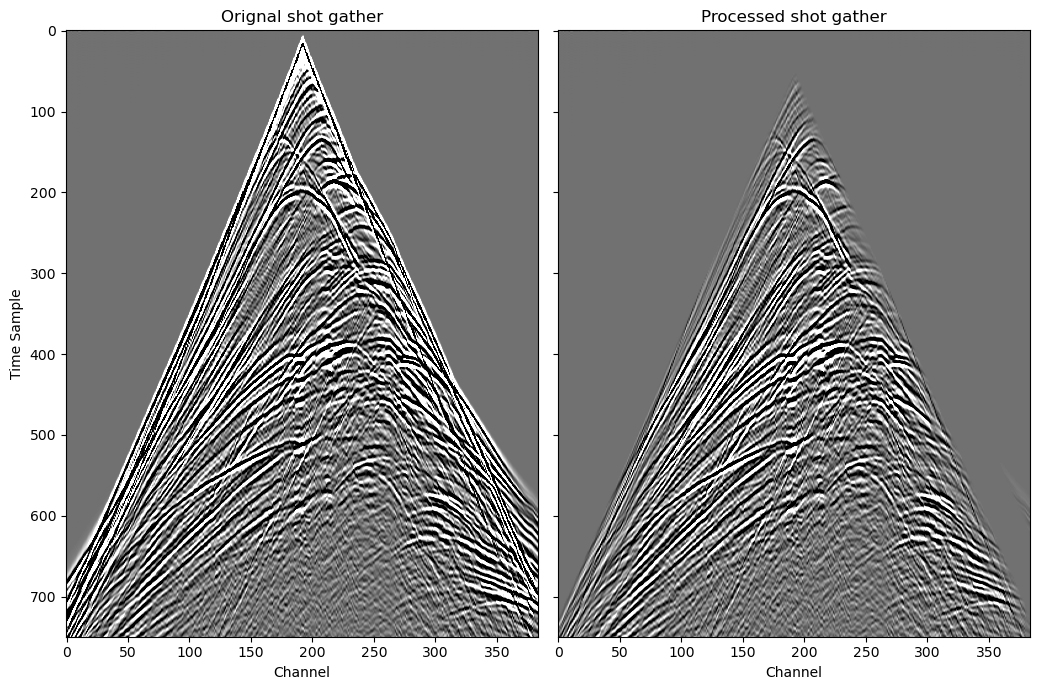

In [20]:
vmin, vmax = torch.quantile(observed_data[0],
                            torch.tensor([0.05, 0.95]).to(device))
_, ax = plt.subplots(1, 2, figsize=(10.5, 7), sharey=True)
ax[0].imshow(observed_data[57].cpu().T, aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax)
ax[1].imshow(observed_scatter_masked[57].cpu().T, aspect='auto', cmap='gray',
             vmin=vmin, vmax=vmax)
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Time Sample")
ax[0].set_title('Orignal shot gather')
ax[1].set_xlabel("Channel")
ax[1].set_title('Processed shot gather')
plt.tight_layout()
plt.savefig('Data_for_RTM.jpg')

We now run the optimisation to invert for the scattering potential. To do this we create an initial scattering model (which is all zeros), and we specify that gradients will need to be calculated with respect to it. We use Stochastic Gradient Descent as the optimiser and the mean-squared error as the loss/objective function. We then forward propagate batches of shots with the Born propagator, apply the mask to the output before comparing with the target (the masked observed data) using the loss function, and backpropagate to add to the gradient with respect to the scattering potential. We could have used a PyTorch data loader to split the data into batches instead of doing it ourselves. We apply a scaling (1e9) to the loss function to boost the amplitude of the update, but this could also be achieved by increasing the learning rate of the optimiser:

In [21]:
# Create scattering amplitude that we will invert for
scatter = torch.zeros_like(v_mig)
scatter.requires_grad_()
scatter.size()

torch.Size([1151, 376])

In [ ]:
# Setup optimiser to perform inversion
optimiser = torch.optim.SGD([scatter], lr=1)
loss_fn = torch.nn.MSELoss()

In [ ]:
# Run optimisation/inversion
n_epochs = 1
n_batch = 46
n_shots_per_batch = (n_shots + n_batch - 1) // n_batch
for epoch in range(n_epochs):
    def closure():
        epoch_loss = 0
        optimiser.zero_grad()
        for batch in range(n_batch):
            batch_start = batch * n_shots_per_batch
            batch_end = min(batch_start + n_shots_per_batch, n_shots)
            if batch_end <= batch_start:
                continue
            out = scalar_born(
                v_mig, scatter, dx, dt,
                source_amplitudes=source_amplitudes[batch_start:batch_end],
                source_locations=source_locations[batch_start:batch_end],
                receiver_locations=receiver_locations[batch_start:batch_end],
                pml_freq=freq
            )
            loss = (
                1e9 * loss_fn(out[-1] * mask[batch_start:batch_end],
                              observed_scatter_masked[batch_start:batch_end])
            )
            epoch_loss += loss.item()
            loss.backward()
        print(epoch_loss)
        return epoch_loss
    optimiser.step(closure)

The resulting image is already quite good after just one iteration. Additional iterations of the optimiser might improve it, but might also require more careful setup for the optimisation to converge to a desirable output.

In [ ]:
# Plot
vmin, vmax = torch.quantile(scatter.detach(),
                            torch.tensor([0.05, 0.95]).to(device))
plt.figure(figsize=(10.5, 3.5))
plt.imshow(scatter.detach().cpu().T, aspect='auto', cmap='gray',
           vmin=vmin, vmax=vmax)
plt.savefig('example_rtm.jpg')



In [ ]:
scatter.detach().cpu().numpy().tofile('marmousi_scatter.bin')